# Streaming application using Spark Structured Streaming

## Table of contents<a class="anchor" id="table"></a>

* [1. Create SparkSession and SparkConf object](#1)
* [2. Ingest streaming data from Kafka producer](#2)
* [3. Transform streaming data](#3)
* [4. Persist transformed streaming data in parquet format](#4)
* [5. Load Machine learning model and make predictions](#5)
* [6. Streaming flight count and rolling mean accuracy](#6)

In [1]:
# Import necessary libraries
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
import datetime as dt
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Load necessary libraries for the ML model
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml import PipelineModel

# For plotting
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Create SparkSession and SparkConf object<a class="anchor" id="1"></a>
[Back to top](#table)

In [2]:
# Create Spark Configuration Object with 2 processors
spark_conf = SparkConf().setMaster('local[2]').setAppName('Flights streaming application')

# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

Note: The following code can be used to set the timezone to UTC but we are already ingesting timestamps that were set as UTC, which would cause the timestamps to be 22 hours behind Melbourne time rather than 11 so I did not include it.

`spark.conf.set("spark.sql.session.timeZone", "UTC")`

## 2. Ingest streaming data from Kafka producer<a class="anchor" id="2"></a>
[Back to top](#table)

In [3]:
# Ingest streaming data
topic = "flightTopic"
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

## 3.Transform streaming data<a class="anchor" id="3"></a>
[Back to top](#table)

Transform into desired tabular format with columns as per metadata.

In [4]:
# Cast data as string
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

# Create list of columns received from producer as string types
stringColList = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 
                 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 
                 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 
                 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY']

# Set the structure for the schema
structure = [StructField('ts', TimestampType(), True)] \
        + [StructField(i, StringType(), True) for i in stringColList]

# Define the schema for the structured datastream received (only keep necessary columns)
schema = ArrayType(StructType(structure))

In [5]:
# Parse according to schema and map
df = df.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value'))
df = df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))

In [6]:
# Set list of columns to unnest and rename
dfColSelect = [F.col("unnested_value.{}".format(c)) \
               .alias("{}".format(c)) \
               for c in (['ts'] + stringColList)
              ]

# Create formatted dataframe by selecting/unnesting columns
dfFormatted = df.select(*dfColSelect)

In [7]:
# Columns to cast to integer type (previous stringColList less the columns we keep as string type)
formatIntCols = list(set(stringColList) - {'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'})

# Cast columns to integer as per metadata
for c in formatIntCols:
    dfFormatted = dfFormatted.withColumn(c, F.col(c).cast('integer'))

In [8]:
# Add binary labels
dfFormatted = dfFormatted.withColumn('binaryArrDelay', F.when(F.col('ARRIVAL_DELAY') > 0, 1).otherwise(0))

# Restrict flightKey to 1, 2 or 3
dfFormatted = dfFormatted.filter(dfFormatted.DAY_OF_WEEK <= 3)

## 4. Persist transformed streaming data in parquet format<a class="anchor" id="4"></a>
[Back to top](#table)

In [9]:
# Write into parquet files (save in currrent working directory)
query_file_sink = dfFormatted\
        .writeStream\
        .format("parquet")\
        .outputMode("append")\
        .option("path", "flight.parquet")\
        .option("checkpointLocation", "checkpoint")\
        .start()

In [10]:
#Stop the writing parquet files
query_file_sink.stop()

## 5. Load Machine learning model and make predictions<a class="anchor" id="5"></a>
[Back to top](#table)

In [11]:
# The ML model needs this transformer (from analysing_flight_delays_data.ipynb) in order to map months to seasons
class monthsToSeasons(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    
    value = Param(Params._dummy(), "value", "value to fill")

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(monthsToSeasons, self).__init__()
        self._setDefault(value=0.0)
        kwargs = self._input_kwargs
        self._set(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, df):
        return df.withColumn(self.getOutputCol(),
                         F.when((F.col(self.getInputCol()).between(3, 5)), 'Spring')\
                        .when((F.col(self.getInputCol()).between(6,8)), 'Summer')\
                        .when((F.col(self.getInputCol()).between(9,11)), 'Autumn')\
                        .otherwise('Winter'))

In [12]:
# Load the pipeline model for predicting arrival delays (Need persisted model from analysing_flight_delays_data.ipynb)
gbtArrDelayModel = PipelineModel.load('arrival_delays_gbt_model')

In [13]:
# Make predictions using the ML model
gbtArrDelayPredictions = gbtArrDelayModel.transform(dfFormatted)

In [14]:
# Add column for accuracy calculation
gbtArrDelayPredictions = gbtArrDelayPredictions\
                            .withColumn('correctPrediction', 
                                        F.when(F.col('binaryArrDelay') == (F.col('prediction')), 1 )
                            .otherwise(0))

In [15]:
# Check final schema
gbtArrDelayPredictions.printSchema()

root
 |-- ts: timestamp (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- binaryArrDelay: integer (nullable = false)
 |-- SEASON: string (nullable = false)
 |-- AIRLINE_index: double (nullable = false)
 |-- ORIGIN_AIRPORT_index

## 6. Streaming flight count and rolling mean accuracy<a class="anchor" id="6"></a>
[Back to top](#table)

In [16]:
# Get count and accuracy window and timestamp
windowedMetrics = gbtArrDelayPredictions \
    .groupBy(
        F.window(gbtArrDelayPredictions.ts, "2 minutes", "10 seconds"),
        gbtArrDelayPredictions.ts,
        gbtArrDelayPredictions.DAY_OF_WEEK)\
    .agg((F.round(100*F.sum("correctPrediction")/F.count('*'),2)).alias("accuracy"),
        F.count("*").alias("count"))

In [17]:
# Select and rename columns
windowedMetrics = windowedMetrics.select(
                    F.col("ts"),
                    F.col("DAY_OF_WEEK").alias("keyFlight"),
                    F.col("accuracy"),
                    F.col("count").alias("countFlightRecords")
                )

In [18]:
# Send output to sink
query = windowedMetrics \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("metrics") \
    .trigger(processingTime='5 seconds') \
    .start()

In [19]:
# Initialise plots
def init_plots():
    
    try:
        # Figure size and spacing
        fig = plt.figure(figsize=(9.5,6))
        fig.subplots_adjust(hspace=0.8)
        
        # Subplot 1 and initial text
        ax1 = fig.add_subplot(211)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Count of flight records')
        ax1.title.set_text('Flights count')
        
        # Subplot 2 and inital text
        ax2 = fig.add_subplot(212)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Accuracy (%)')
        ax2.title.set_text('Prediction accumulated mean accuracy of late flights')
        
        # Title and display
        fig.suptitle('US flights data stream') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        
        return fig, ax1, ax2
    
    except Exception as ex:
        print(str(ex))

**Note**: The code for printing outputs is at the bottom of the next cell:

**Option 1**: When new data is received, print the outputs pertaining to the new data. Prevents the output from getting to long. This option only prints data for the last 2 timestamps for each key (e.g. batch X is the most recent timestamp and batch Y is the previous timestamp). Other data in the window will not have changed from the previous window.<br>
**Option 2**: When new data is received, print the outputs pertaining to the entire 2-minute window.

I left option 1 in the code intentionally as an option, but commented it out.

<IPython.core.display.Javascript object>


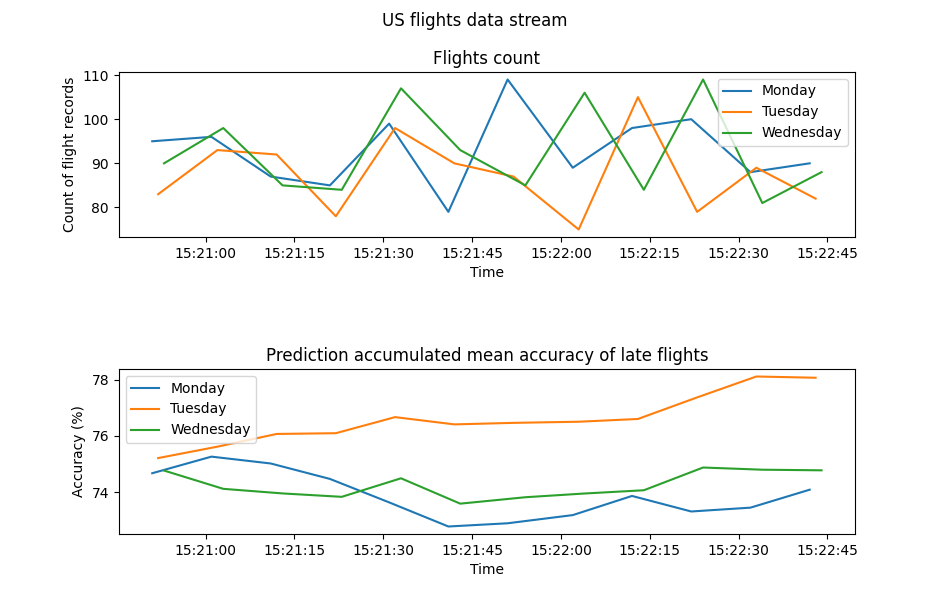

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:16:41;  countFlights: 6;    accumMeanAccuracy: 83.33
ts: 2021-10-15 15:16:51;  countFlights: 97;   accumMeanAccuracy: 80.84
	
ts: 2021-10-15 15:16:42;  countFlights: 9;    accumMeanAccuracy: 100.0
ts: 2021-10-15 15:16:52;  countFlights: 77;   accumMeanAccuracy: 89.61
	
ts: 2021-10-15 15:16:43;  countFlights: 10;   accumMeanAccuracy: 100.0
ts: 2021-10-15 15:16:53;  countFlights: 86;   accumMeanAccuracy: 89.53
	
-----------------------------------------------------------------------------------
ts: 2021-10-15 15:16:41;  countFlights: 6;    accumMeanAccuracy: 83.33
ts: 2021-10-15 15:16:51;  countFlights: 106;  accumMeanAccuracy: 79.88
ts: 2021-10-15 15:17:01;  countFlights: 80;   accumMeanAccuracy: 78.67
	
ts: 2021-10-15 15:16:42;  countFlights: 9;    accumMeanAccuracy: 100.0
ts: 2021-10-15 15:16:52;  countFlights: 84;   accumMeanAccuracy: 90.47
ts: 2021-10-15 15:17:02;  countFlights: 89;

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:16:41;  countFlights: 6;    accumMeanAccuracy: 83.33
ts: 2021-10-15 15:16:51;  countFlights: 106;  accumMeanAccuracy: 79.88
ts: 2021-10-15 15:17:01;  countFlights: 86;   accumMeanAccuracy: 76.0
ts: 2021-10-15 15:17:11;  countFlights: 96;   accumMeanAccuracy: 77.38
ts: 2021-10-15 15:17:21;  countFlights: 106;  accumMeanAccuracy: 78.27
ts: 2021-10-15 15:17:31;  countFlights: 87;   accumMeanAccuracy: 74.88
ts: 2021-10-15 15:17:41;  countFlights: 89;   accumMeanAccuracy: 74.97
ts: 2021-10-15 15:17:51;  countFlights: 106;  accumMeanAccuracy: 76.03
ts: 2021-10-15 15:18:01;  countFlights: 97;   accumMeanAccuracy: 75.92
ts: 2021-10-15 15:18:11;  countFlights: 93;   accumMeanAccuracy: 76.29
	
ts: 2021-10-15 15:16:42;  countFlights: 9;    accumMeanAccuracy: 100.0
ts: 2021-10-15 15:16:52;  countFlights: 84;   accumMeanAccuracy: 90.47
ts: 2021-10-15 15:17:02;  countFlights: 94;   accumMeanAccuracy

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:17:01;  countFlights: 86;   accumMeanAccuracy: 78.44
ts: 2021-10-15 15:17:11;  countFlights: 96;   accumMeanAccuracy: 78.62
ts: 2021-10-15 15:17:21;  countFlights: 106;  accumMeanAccuracy: 78.37
ts: 2021-10-15 15:17:31;  countFlights: 87;   accumMeanAccuracy: 77.38
ts: 2021-10-15 15:17:41;  countFlights: 89;   accumMeanAccuracy: 77.4
ts: 2021-10-15 15:17:51;  countFlights: 106;  accumMeanAccuracy: 77.04
ts: 2021-10-15 15:18:01;  countFlights: 97;   accumMeanAccuracy: 77.07
ts: 2021-10-15 15:18:11;  countFlights: 98;   accumMeanAccuracy: 77.02
ts: 2021-10-15 15:18:21;  countFlights: 86;   accumMeanAccuracy: 77.42
ts: 2021-10-15 15:18:31;  countFlights: 98;   accumMeanAccuracy: 77.17
ts: 2021-10-15 15:18:41;  countFlights: 92;   accumMeanAccuracy: 76.66
ts: 2021-10-15 15:18:51;  countFlights: 81;   accumMeanAccuracy: 76.05
	
ts: 2021-10-15 15:17:02;  countFlights: 94;   accumMeanAccuracy

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:17:41;  countFlights: 89;   accumMeanAccuracy: 77.4
ts: 2021-10-15 15:17:51;  countFlights: 106;  accumMeanAccuracy: 77.04
ts: 2021-10-15 15:18:01;  countFlights: 97;   accumMeanAccuracy: 77.07
ts: 2021-10-15 15:18:11;  countFlights: 98;   accumMeanAccuracy: 77.02
ts: 2021-10-15 15:18:21;  countFlights: 86;   accumMeanAccuracy: 77.42
ts: 2021-10-15 15:18:31;  countFlights: 98;   accumMeanAccuracy: 77.17
ts: 2021-10-15 15:18:41;  countFlights: 92;   accumMeanAccuracy: 76.66
ts: 2021-10-15 15:18:51;  countFlights: 91;   accumMeanAccuracy: 76.06
ts: 2021-10-15 15:19:01;  countFlights: 93;   accumMeanAccuracy: 75.94
ts: 2021-10-15 15:19:11;  countFlights: 102;  accumMeanAccuracy: 75.72
ts: 2021-10-15 15:19:21;  countFlights: 98;   accumMeanAccuracy: 75.31
ts: 2021-10-15 15:19:31;  countFlights: 81;   accumMeanAccuracy: 76.17
	
ts: 2021-10-15 15:17:42;  countFlights: 77;   accumMeanAccuracy

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:18:21;  countFlights: 86;   accumMeanAccuracy: 77.42
ts: 2021-10-15 15:18:31;  countFlights: 98;   accumMeanAccuracy: 77.17
ts: 2021-10-15 15:18:41;  countFlights: 92;   accumMeanAccuracy: 76.66
ts: 2021-10-15 15:18:51;  countFlights: 91;   accumMeanAccuracy: 76.06
ts: 2021-10-15 15:19:01;  countFlights: 93;   accumMeanAccuracy: 75.94
ts: 2021-10-15 15:19:11;  countFlights: 102;  accumMeanAccuracy: 75.72
ts: 2021-10-15 15:19:21;  countFlights: 98;   accumMeanAccuracy: 75.31
ts: 2021-10-15 15:19:31;  countFlights: 86;   accumMeanAccuracy: 76.25
ts: 2021-10-15 15:19:41;  countFlights: 87;   accumMeanAccuracy: 76.98
ts: 2021-10-15 15:19:51;  countFlights: 85;   accumMeanAccuracy: 76.84
ts: 2021-10-15 15:20:01;  countFlights: 96;   accumMeanAccuracy: 76.48
ts: 2021-10-15 15:20:11;  countFlights: 95;   accumMeanAccuracy: 75.71
	
ts: 2021-10-15 15:18:22;  countFlights: 97;   accumMeanAccurac

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:19:01;  countFlights: 93;   accumMeanAccuracy: 75.94
ts: 2021-10-15 15:19:11;  countFlights: 102;  accumMeanAccuracy: 75.72
ts: 2021-10-15 15:19:21;  countFlights: 98;   accumMeanAccuracy: 75.31
ts: 2021-10-15 15:19:31;  countFlights: 86;   accumMeanAccuracy: 76.25
ts: 2021-10-15 15:19:41;  countFlights: 87;   accumMeanAccuracy: 76.98
ts: 2021-10-15 15:19:51;  countFlights: 85;   accumMeanAccuracy: 76.84
ts: 2021-10-15 15:20:01;  countFlights: 96;   accumMeanAccuracy: 76.48
ts: 2021-10-15 15:20:11;  countFlights: 101;  accumMeanAccuracy: 75.63
ts: 2021-10-15 15:20:21;  countFlights: 82;   accumMeanAccuracy: 75.14
ts: 2021-10-15 15:20:31;  countFlights: 78;   accumMeanAccuracy: 75.24
ts: 2021-10-15 15:20:41;  countFlights: 80;   accumMeanAccuracy: 74.75
ts: 2021-10-15 15:20:51;  countFlights: 89;   accumMeanAccuracy: 74.69
	
ts: 2021-10-15 15:19:02;  countFlights: 110;  accumMeanAccurac

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:19:41;  countFlights: 87;   accumMeanAccuracy: 76.98
ts: 2021-10-15 15:19:51;  countFlights: 85;   accumMeanAccuracy: 76.84
ts: 2021-10-15 15:20:01;  countFlights: 96;   accumMeanAccuracy: 76.48
ts: 2021-10-15 15:20:11;  countFlights: 101;  accumMeanAccuracy: 75.63
ts: 2021-10-15 15:20:21;  countFlights: 82;   accumMeanAccuracy: 75.14
ts: 2021-10-15 15:20:31;  countFlights: 78;   accumMeanAccuracy: 75.24
ts: 2021-10-15 15:20:41;  countFlights: 80;   accumMeanAccuracy: 74.75
ts: 2021-10-15 15:20:51;  countFlights: 95;   accumMeanAccuracy: 74.68
ts: 2021-10-15 15:21:01;  countFlights: 96;   accumMeanAccuracy: 75.27
ts: 2021-10-15 15:21:11;  countFlights: 87;   accumMeanAccuracy: 75.03
ts: 2021-10-15 15:21:21;  countFlights: 85;   accumMeanAccuracy: 74.48
ts: 2021-10-15 15:21:31;  countFlights: 90;   accumMeanAccuracy: 73.8
	
ts: 2021-10-15 15:19:42;  countFlights: 89;   accumMeanAccuracy

-----------------------------------------------------------------------------------
ts: 2021-10-15 15:20:21;  countFlights: 82;   accumMeanAccuracy: 75.14
ts: 2021-10-15 15:20:31;  countFlights: 78;   accumMeanAccuracy: 75.24
ts: 2021-10-15 15:20:41;  countFlights: 80;   accumMeanAccuracy: 74.75
ts: 2021-10-15 15:20:51;  countFlights: 95;   accumMeanAccuracy: 74.68
ts: 2021-10-15 15:21:01;  countFlights: 96;   accumMeanAccuracy: 75.27
ts: 2021-10-15 15:21:11;  countFlights: 87;   accumMeanAccuracy: 75.03
ts: 2021-10-15 15:21:21;  countFlights: 85;   accumMeanAccuracy: 74.48
ts: 2021-10-15 15:21:31;  countFlights: 99;   accumMeanAccuracy: 73.65
ts: 2021-10-15 15:21:41;  countFlights: 79;   accumMeanAccuracy: 72.79
ts: 2021-10-15 15:21:51;  countFlights: 109;  accumMeanAccuracy: 72.91
ts: 2021-10-15 15:22:02;  countFlights: 89;   accumMeanAccuracy: 73.2
ts: 2021-10-15 15:22:12;  countFlights: 89;   accumMeanAccuracy: 74.03
	
ts: 2021-10-15 15:20:22;  countFlights: 97;   accumMeanAccuracy

In [20]:
# Initialise empty plot
fig, ax1, ax2 = init_plots()

# For the legend
# Labels are based on metadata, which is consistent with the correct day
labels = ['Monday', 'Tuesday', 'Wednesday']

startTime = dt.datetime.now().timestamp()

# Initialise any value (will be used to update printing results)
tsBenchmark = ''

# Run for up to 6 minutes (360 seconds)
while dt.datetime.now().timestamp() - startTime < 360:
    
    ## STEP 1: Extract the data needed from the query to pandas
    # Attain the correct data to plot
    windowDf = spark.sql('''
        SELECT DISTINCT ts, keyFlight, accuracy, countFlightRecords
        FROM metrics
        WHERE ts IN (SELECT distinct(ts) 
                    FROM metrics
                    ORDER BY ts desc limit 72)
        ORDER BY ts
        ''').toPandas()
    
    
    ## STEP 2: Get the data from pandas into lists
    # Initialise lists to store sub-lists
    countFlightRecords = [[] for _ in range(3)]
    acc = [[] for _ in range(3)]
    x = [[] for _ in range(3)]

    # Generate data for sub-lists for keyFlights = 1,2,3
    for i in range(3):
        countFlightRecords[i] = windowDf['countFlightRecords'][windowDf['keyFlight']==i+1].to_list()
        acc[i] = windowDf['accuracy'][windowDf['keyFlight']==i+1].to_list()
        x[i] = windowDf['ts'][windowDf['keyFlight']==i+1].to_list()
    
        # Remove excess values (we only need older values for accuracy rolling mean calculation)
        # If we have more than 12 values for timestamp or countFlightRecords, drop them
        if len(countFlightRecords[i]) > 12:
            countFlightRecords[i] = countFlightRecords[i][len(countFlightRecords[i])-12:]
        if len(x[i]) > 12:
            x[i] = x[i][len(x[i])-12:]
    
    
    ## STEP 3: Calculate 2-minute rolling mean accuracy for each keyFlight
    accumMeanAccuracy = [[] for _ in range(3)]

    for i in range(3):

        # Iterate through acc
        for j in range(len(acc[i])):

            # Moving average of last value + up to 11 past values
            try:
                accumMeanAccuracy[i].append(sum(acc[i][j-11:j+1])/len(acc[i][j-11:j+1]))
            # If fewer than 12 values
            except:
                accumMeanAccuracy[i].append(sum(acc[i][:j+1])/len(acc[i][:j+1]))

        # Remove any values used to calculate moving average but which we are not plotting
        if len(accumMeanAccuracy[i]) > 12:
            accumMeanAccuracy[i] = accumMeanAccuracy[i][len(accumMeanAccuracy[i])-12:]
       
        
    ## STEP 4: Plotting
    # Reset plots
    ax1.clear()
    ax2.clear()
    
    # Plot both subplots for each keyFlights
    for i in range(3):
        ax1.plot(x[i], countFlightRecords[i], label=labels[i])
        ax2.plot(x[i], accumMeanAccuracy[i], label=labels[i])
        
    # Set axes labels again
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Count of flight records')
    ax1.title.set_text('Flights count')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Accuracy (%)')
    ax2.title.set_text('Prediction accumulated mean accuracy of late flights')
    
    ax1.legend() # Display legend
    ax2.legend() # Display legend
    fig.canvas.draw() # Draw
    
    
    ## STEP 5: Print output if we have new data
    if x[0] and x[0][-1] != tsBenchmark:
            print('-----------------------------------------------------------------------------------')
            for i in range(3):
                
#                 # OPTION 1: Print only the latest data to the terminal
#                 if len(x[0]) > 1:
#                     print("flightKey: {}  ts: {}  countFlights: {} accumMeanAccuracy: {}"\
#                           .format((i+1),
#                                   x[i][len(x[i])-2],
#                                   (str(countFlightRecords[i][len(x[i])-2])).ljust(5),
#                                   round(accumMeanAccuracy[i][len(x[i])-2],2)
#                                  )
#                          )
#                 print("flightKey: {}  ts: {}  countFlights: {} accumMeanAccuracy: {}"\
#                       .format((i+1),
#                               x[i][len(x[i])-1],
#                               (str(countFlightRecords[i][len(x[i])-1])).ljust(5),
#                               round(accumMeanAccuracy[i][len(x[i])-1],2)
#                              )
#                      )
                
                # OPTION 2: Print all data from the latest window to the terminal when new data comes in
                for j,k,l in zip(x[i],countFlightRecords[i],accumMeanAccuracy[i]):
                    print("ts: {};  countFlights: {} accumMeanAccuracy: {}"\
                          .format(j,
                                  (str(k)+';').ljust(5),
                                  round(l,2)
                                 )
                         )
                print('\t')
 
            # Update benchmark check
            tsBenchmark = x[0][-1]

In [21]:
query.stop()